# Weighted ELM regression

Notebook to perform an elm with sine activation functions weighted regression


### 1) Imports

In [27]:
#utilities
import numpy as np 
import pandas as pd
# pd.set_option('display.max_colwidth', -1)
import matplotlib.pyplot as plt
import seaborn as sns
seaborn_blue=(0.2980392156862745, 0.4470588235294118, 0.6901960784313725)
seaborn_orange=(0.8666666666666667, 0.5176470588235295, 0.3215686274509804)
seaborn_green=(0.3333333333333333, 0.6588235294117647, 0.40784313725490196)
sns.set()
plt.rc('xtick', labelsize=15) 
plt.rc('ytick', labelsize=15) 
import itertools
from tqdm import tqdm
import time

from sklearn.metrics import mean_squared_error,max_error

import warnings
# warnings.simplefilter(action='ignore', category=FutureWarning)
# warnings.filterwarnings('ignore')


sns.set()
plt.rc('xtick', labelsize=15) 
plt.rc('ytick', labelsize=15) 

plt.rcParams['figure.figsize'] = (15, 8)

sns.set_style("ticks",{"axes.facecolor":'white'})
sns.set_context("paper",font_scale=2.3)
from scipy.linalg import pinv2
from weighted_elm import *

#parametric function to retuen error and weight for regression
def assign_error_weight(time, initial_error, final_error):
    '''
    time in jd
    errors in meters
    '''
    initial_error/=1000 #from m to km
    final_error/=1000
    time=time-time[0]  #start from t=0
    error=initial_error+(final_error-initial_error)/(time[-1]-time[0])*time
#     weight=(error[-1]-error)*1e2+2
    return error,1/error

### 2) Read Data: propagated and reference ephemeris

In [28]:
prop_ephe_name="G01_orbit_ECEF_b.txt"
error_profile_name="G01_orbit_ECEF_error_profile.txt"
days=1 #how many days of propagated orbits to approximate

In [29]:
"""
Example of how the propagated (first cell below) and error profile (second cell below) files should be structured (without the # at the beginning of the row)
Datapoints must be provided every minute
"""

'\nExample of how the propagated (first cell below) and error profile (second cell below) files should be structured (without the # at the beginning of the row)\nDatapoints must be provided every minute\n'

In [30]:
# % GPSTIME                             X                       Y                       Z                       VX                       VY                      VZ         
#    2458736.5      0.0000000000    -0.14191298395000E+08    0.43338783220000E+07    0.21811823968000E+08   -0.53278189718677E+03   -0.27647244092224E+04    0.23153739817080E+03
#    2458736.5      0.0006944444    -0.14223572127618E+08    0.41680094087114E+07    0.21824863699006E+08   -0.54300366151162E+03   -0.27641970348062E+04    0.20311821412304E+03
#    2458736.5      0.0013888889    -0.14256458138822E+08    0.40021797371790E+07    0.21836197931779E+08   -0.55319072008632E+03   -0.27634164179937E+04    0.17468783620157E+03
#    2458736.5      0.0020833333    -0.14289954263030E+08    0.38364044893906E+07    0.21845826062743E+08   -0.56334029945128E+03   -0.27623829842186E+04    0.14624853281378E+03
#    2458736.5      0.0027777778    -0.14324058168446E+08    0.36706988205974E+07    0.21853747624404E+08   -0.57344963257647E+03   -0.27610971990579E+04    0.11780257161117E+03
#    2458736.5      0.0034722222    -0.14358767357457E+08    0.35050778569139E+07    0.21859962285299E+08   -0.58351595937665E+03   -0.27595595681200E+04    0.89352219288812E+02
#    2458736.5      0.0041666667    -0.14394079167066E+08    0.33395566929203E+07    0.21864469849932E+08   -0.59353652722417E+03   -0.27577706369259E+04    0.60899741385237E+02
#    2458736.5      0.0048611111    -0.14429990769355E+08    0.31741503892730E+07    0.21867270258703E+08   -0.60350859146020E+03   -0.27557309907827E+04    0.32447402082873E+02
#    2458736.5      0.0055555556    -0.14466499171979E+08    0.30088739703170E+07    0.21868363587813E+08   -0.61342941590286E+03   -0.27534412546510E+04    0.39974640091374E+01
#    2458736.5      0.0062500000    -0.14503601218687E+08    0.28437424217166E+07    0.21867750049173E+08   -0.62329627335519E+03   -0.27509020930039E+04   -0.24447811961847E+02
#    2458736.5      0.0069444444    -0.14541293589881E+08    0.26787706880823E+07    0.21865429990286E+08   -0.63310644610861E+03   -0.27481142096800E+04   -0.52886166906865E+02
#    2458736.5      0.0076388889    -0.14579572803196E+08    0.25139736706204E+07    0.21861403894128E+08   -0.64285722644685E+03   -0.27450783477288E+04   -0.81315344050532E+02
#    2458736.5      0.0083333333    -0.14618435214116E+08    0.23493662247803E+07    0.21855672379013E+08   -0.65254591714517E+03   -0.27417952892494E+04   -0.10973308896152E+03
#    2458736.5      0.0090277778    -0.14657877016620E+08    0.21849631579190E+07    0.21848236198444E+08   -0.66216983196864E+03   -0.27382658552218E+04   -0.13813714974802E+03
#    2458736.5      0.0097222222    -0.14697894243855E+08    0.20207792269722E+07    0.21839096240957E+08   -0.67172629616723E+03   -0.27344909053321E+04   -0.16652527725251E+03
#    2458736.5      0.0104166667    -0.14738482768839E+08    0.18568291361374E+07    0.21828253529952E+08   -0.68121264696843E+03   -0.27304713377900E+04   -0.19489522524570E+03
#    2458736.5      0.0111111111    -0.14779638305194E+08    0.16931275345688E+07    0.21815709223509E+08   -0.69062623406744E+03   -0.27262080891400E+04   -0.22324475061968E+03
#    2458736.5      0.0118055556    -0.14821356407914E+08    0.15296890140834E+07    0.21801464614195E+08   -0.69996442011436E+03   -0.27217021340658E+04   -0.25157161358032E+03
#    2458736.5      0.0125000000    -0.14863632474148E+08    0.13665281068767E+07    0.21785521128861E+08   -0.70922458119825E+03   -0.27169544851878E+04   -0.27987357783875E+03
#    2458736.5      0.0131944444    -0.14906461744029E+08    0.12036592832560E+07    0.21767880328428E+08   -0.71840410732905E+03   -0.27119661928538E+04   -0.30814841080202E+03
#    2458736.5      0.0138888889    -0.14949839301519E+08    0.10410969493795E+07    0.21748543907653E+08   -0.72750040291523E+03   -0.27067383449241E+04   -0.33639388376291E+03
#    2458736.5      0.0145833333    -0.14993760075287E+08    0.87885544501454E+06    0.21727513694897E+08   -0.73651088723945E+03   -0.27012720665483E+04   -0.36460777208884E+03
#    2458736.5      0.0152777778    -0.15038218839620E+08    0.71694904130709E+06    0.21704791651870E+08   -0.74543299493050E+03   -0.26955685199371E+04   -0.39278785540980E+03
#    2458736.5      0.0159722222    -0.15083210215352E+08    0.55539193856312E+06    0.21680379873373E+08   -0.75426417643166E+03   -0.26896289041275E+04   -0.42093191780546E+03

In [31]:
# % GPSTIME                             err_X                       err_Y                       err_Z  
# 2458736.5    0.000000000000000    0.000000000000000E+00    0.000000000000000E+00    0.000000000000000E+00
# 2458736.5    0.010416666511446    -2.081610001623631E-01    -4.913739999756217E-02    1.370479986071587E-01
# 2458736.5    0.020833333488554    -4.051130004227161E-01    -7.244647992774844E-02    2.802380025386810E-01
# 2458736.5    0.031250000000000    -5.948279984295368E-01    -7.339730020612478E-02    4.373049996793270E-01
# 2458736.5    0.041666666511446    -7.782269977033138E-01    -5.565130058676004E-02    6.156949996948242E-01
# 2458736.5    0.052083333022892    -9.647810012102127E-01    -3.021580073982477E-02    8.190749995410442E-01
# 2458736.5    0.062500000000000    -1.158835999667645E+00    -1.707199960947037E-03    1.051198000088334E+00
# 2458736.5    0.072916666511446    -1.372055001556873E+00    1.934500038623810E-02    1.311029000207782E+00
# 2458736.5    0.083333333488554    -1.616268999874592E+00    2.476599998772144E-02    1.594440000131726E+00
# 2458736.5    0.093750000000000    -1.901973001658916E+00    1.037199981510639E-02    1.896895198151469E+00
# 2458736.5    0.104166666977108    -2.241815999150276E+00    -2.991000004112720E-02    2.205254199914634E+00
# 2458736.5    0.114583333488554    -2.648016996681690E+00    -9.696399979293346E-02    2.506906999740750E+00
# 2458736.5    0.125000000000000    -3.128696002066135E+00    -1.899989992380142E-01    2.785940500209108E+00
# 2458736.5    0.135416666511446    -3.694026000797749E+00    -3.061870001256466E-01    3.022892899811268E+00
# 2458736.5    0.145833333488554    -4.345786999911070E+00    -4.393290001899004E-01    3.196652900427580E+00
# 2458736.5    0.156250000000000    -5.086013000458479E+00    -5.838239993900061E-01    3.288310199975967E+00
# 2458736.5    0.166666666511446    -5.911387998610735E+00    -7.302949987351894E-01    3.276436397805810E+00
# 2458736.5    0.177083333022892    -6.812465999275446E+00    -8.720520008355379E-01    3.138940999284387E+00
# 2458736.5    0.187500000000000    -7.776937998831272E+00    -1.003715999424458E+00    2.858458001166582E+00
# 2458736.5    0.197916666511446    -8.788873000070453E+00    -1.119202999398112E+00    2.415173999965191E+00
# 2458736.5    0.208333333488554    -9.827125998213887E+00    -1.217677000910044E+00    1.796556998044252E+00
# 2458736.5    0.218750000000000    -1.086915099993348E+01    -1.300078000873327E+00    9.917140007019043E-01

In [32]:
#read propagated orbit
prop = np.genfromtxt(prop_ephe_name,comments='%')

prop[:,2:]/=1000 #convert to km
prop_15=prop[::15]
t_p = prop[:,0] + prop[:,1]
x_p = prop[:,2]
y_p = prop[:,3]
z_p = prop[:,4]
prop_data=np.vstack((t_p,x_p,y_p,z_p)).T
prop15=np.vstack((prop_15[:,0]+prop_15[:,1],
                    prop_15[:,2],prop_15[:,3],prop_15[:,4])).T

In [33]:
idx=96*days
T = prop15[:idx,0]
X = prop15[:idx,1].reshape(-1,1)
from sklearn.preprocessing import MinMaxScaler
T_scaler = MinMaxScaler(feature_range=(-1,1))
T_scaler.fit(T.reshape(-1,1))
rescaled_T=T_scaler.transform(T.reshape(-1,1))

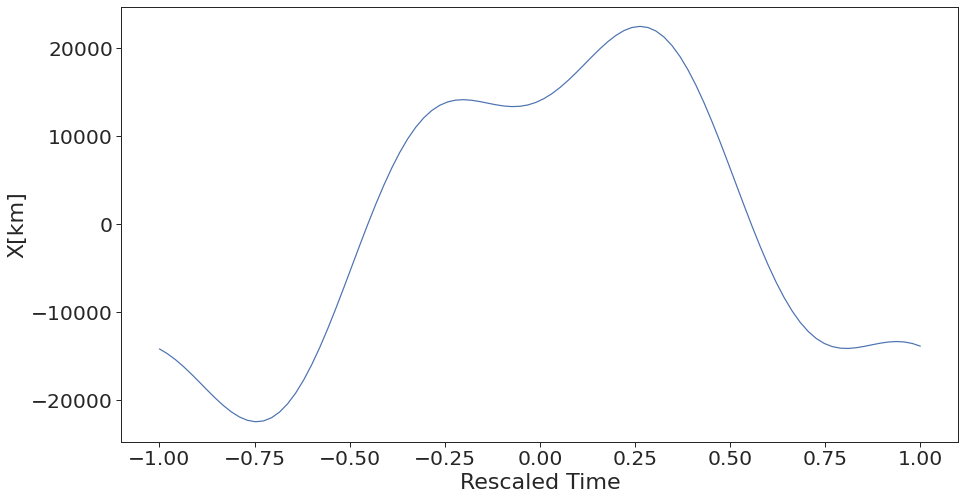

In [34]:
plt.plot(rescaled_T,X)
plt.xlabel("Rescaled Time")
plt.ylabel("X[km]");

### 3) Assign error profile parametrization and weight

In [35]:
error_profile=np.genfromtxt(error_profile_name,comments="%")
x_err=error_profile[:idx,2]

initial_error = .01 #in meters
final_error = x_err[-1]

measure_error, weights_array = assign_error_weight(T,initial_error,final_error)  
tolerance = 1e-2

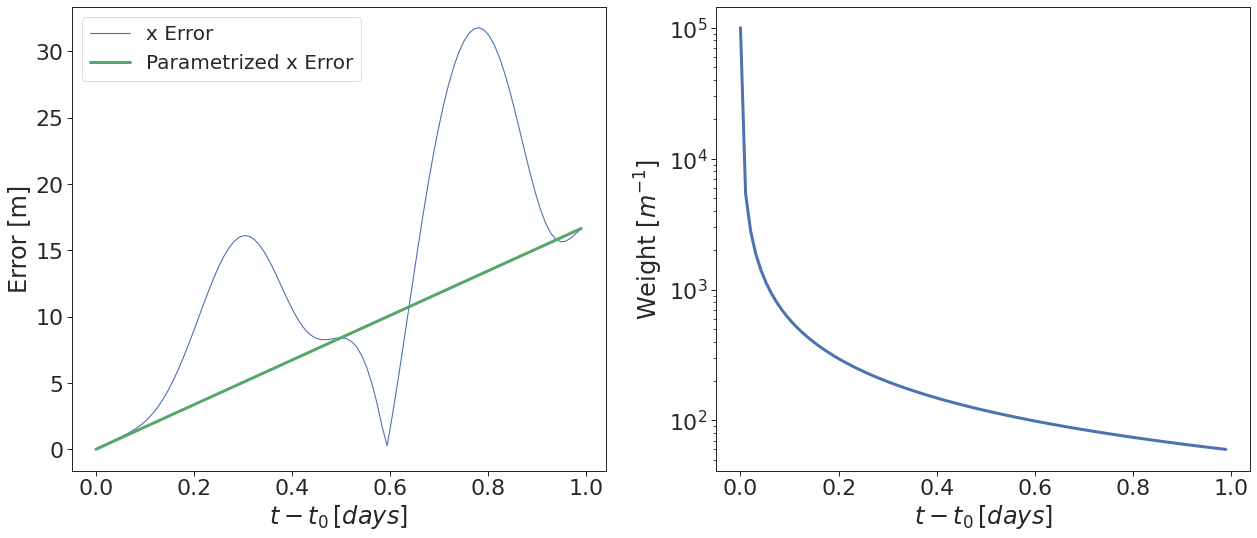

In [36]:
sns.set_context("paper",font_scale=2.5)
fig,ax = plt.subplots(1,2,figsize=(18,8),sharex=True)
plt.rc('xtick') 
plt.rc('ytick') 
ax[0].plot(T-T[0],abs(x_err),label="x Error",linewidth=1.1)
ax[0].plot(T-T[0],measure_error*1000,linewidth=3,label="Parametrized x Error",c=seaborn_green)
ax[0].legend(fontsize=20)
ax[1].plot(T-T[0],weights_array,linewidth=3)

ax[1].set_yscale("log")

ax[0].set_xlabel("$t-t_0\,[days]$");
ax[0].set_ylabel("Error [m]");
ax[1].set_xlabel("$t-t_0\,[days]$");
ax[1].set_ylabel("Weight $[m^{-1}]$");
plt.rc('xtick') 
plt.rc('ytick') 
fig.tight_layout()
# plt.savefig("logs_plots/"+str(days)+"d_linerror_weight.png",dpi=300)

### 4) Compute ELM weighted regression


In [37]:
def find_minimum_N(rescaled_T,X,measure_error,weights_array,tolerance,N):
    """
    INPUTS
        rescaled_T: array with values [-1,1]
        X: array, coordinate to approximate
        weights_array: array of weights associated to every data point (rescaled_T,X)
        tolerance: float
        N: int, initial number of hidden neurons
    
    OUTPUTS
        N: int, minimum number of hidden neurons found
        rms_trials[best_idx]: float, rms found for N hidden neurons
        best_w_seed: int, best random seed for hidden weights (frequencies)
        best_b_seed: int, best random seed for hidden biases (phases)
    """

    
    #start search
    while True:
        print("Hidden size:",N)
        rms_trials=[]
        w_seeds=[]
        b_seeds=[]
        
        for trial in tqdm(range(10000)):
            weight_seed = np.random.randint(1e9)
            bias_seed = np.random.randint(1e9)
            model = elm(hidden_units=N,
                        x=rescaled_T, y=X,
                        w=weights_array,
                        weight_seed=weight_seed,bias_seed=bias_seed)
            beta = model.fit()
            
            pred_data=model.predict(rescaled_T).reshape(-1)
            error=abs(pred_data-X.reshape(-1))*1000
            if (error-measure_error*1000).max()<tolerance: #& ((error-measure_error*1000).max()<tolerance):
                print("ok,",N)
                rms=mean_squared_error(pred_data,X,squared=False)*1000
                rms_trials.append(rms)
                w_seeds.append(weight_seed)
                b_seeds.append(bias_seed)
        
        if len(rms_trials)>=1:
            best_idx=np.argmin(rms_trials)
            best_w_seed=w_seeds[best_idx]
            best_b_seed=b_seeds[best_idx]
            return N, rms_trials[best_idx],best_w_seed,best_b_seed
        else:
            N+=1

In [38]:
N, rms, best_w_seed, best_b_seed=find_minimum_N(rescaled_T, X, measure_error, weights_array, tolerance, 20)

  1%|▏         | 140/10000 [00:00<00:07, 1394.73it/s]

Hidden size: 20


  1%|          | 119/10000 [00:00<00:08, 1182.17it/s]

Hidden size: 21
ok, 21


  8%|▊         | 763/10000 [00:00<00:06, 1506.09it/s]

ok, 21
ok, 21


 13%|█▎        | 1337/10000 [00:00<00:04, 1782.84it/s]

ok, 21


 19%|█▉        | 1915/10000 [00:01<00:04, 1790.15it/s]

ok, 21


 25%|██▍       | 2488/10000 [00:01<00:04, 1859.17it/s]

ok, 21
ok, 21


 31%|███       | 3057/10000 [00:01<00:03, 1876.58it/s]

ok, 21
ok, 21


 38%|███▊      | 3816/10000 [00:02<00:03, 1879.22it/s]

ok, 21


 50%|█████     | 5043/10000 [00:02<00:02, 2054.15it/s]

ok, 21
ok, 21


 54%|█████▍    | 5448/10000 [00:02<00:02, 1956.98it/s]

ok, 21


 70%|███████   | 7018/10000 [00:03<00:01, 1925.53it/s]

ok, 21
ok, 21


 76%|███████▌  | 7599/10000 [00:04<00:01, 1904.28it/s]

ok, 21


 90%|████████▉ | 8984/10000 [00:04<00:00, 1906.94it/s]

ok, 21
ok, 21


100%|██████████| 10000/10000 [00:05<00:00, 1868.16it/s]

ok, 21
ok, 21


In [39]:
print("#####################","\nMinimum N results:","\nN:",N,
      "\nRMS[m]:",rms.round(3),
      "\nWeight Seed:",best_w_seed,
      "\nBias Seed:",best_b_seed,
      "\n#####################\n")

#fit model with minimum N
model = elm(hidden_units=N,
                        x=rescaled_T, y=X.reshape(-1,1),
                        w=weights_array,
                        weight_seed=best_w_seed,bias_seed=best_b_seed)

#beta[0] are the amplitudes
beta = model.fit()

elm_pred_data = model.predict(rescaled_T)
elm_error = (elm_pred_data.reshape(-1)-X.reshape(-1))*1000
elm_mse = mean_squared_error(elm_pred_data,X,squared=False)*1000
elm_max=max_error(elm_pred_data,X)*1000
print("max error",elm_max.round(3))
print("rmse",elm_mse.round(3))

##################### 
Minimum N results: 
N: 21 
RMS[m]: 1.368 
Weight Seed: 368623519 
Bias Seed: 221799650 
#####################

max error 4.294
rmse 1.368


In [40]:
#save to file
np.savez_compressed("w_elm_coeffs",A=beta[0],ws=best_w_seed,bs=best_b_seed)

### Polynomial Regression for comparison

In [41]:
def find_minimum_N_poly(rescaled_T,X,measure_error,weights_array,tolerance):
    N=int(len(rescaled_T)/5)
    #start search
    while True:
        print("Poly Deg:",N)
        c_poly = np.polynomial.chebyshev.chebfit(rescaled_T,X,deg=N,w=weights_array)
        pred_data = np.polynomial.Chebyshev(c_poly)(rescaled_T)
        error=abs(pred_data-X)*1000
        if (error-measure_error*1000).max()<tolerance:
            rms=mean_squared_error(pred_data,X,squared=False)*1000
            return N, rms
        else:
            N+=1

In [42]:
n,rms=find_minimum_N_poly(rescaled_T.reshape(-1),X.reshape(-1), measure_error, weights_array, tolerance)

Poly Deg: 19
Poly Deg: 20
Poly Deg: 21
Poly Deg: 22
Poly Deg: 23
Poly Deg: 24
Poly Deg: 25
Poly Deg: 26
Poly Deg: 27


### 4) compare results

##################### 
Minimum poly deg results: 
N: 27 
RMS[m]: 0.9128314278012797 
#####################

max error 1.742
rmse 0.913


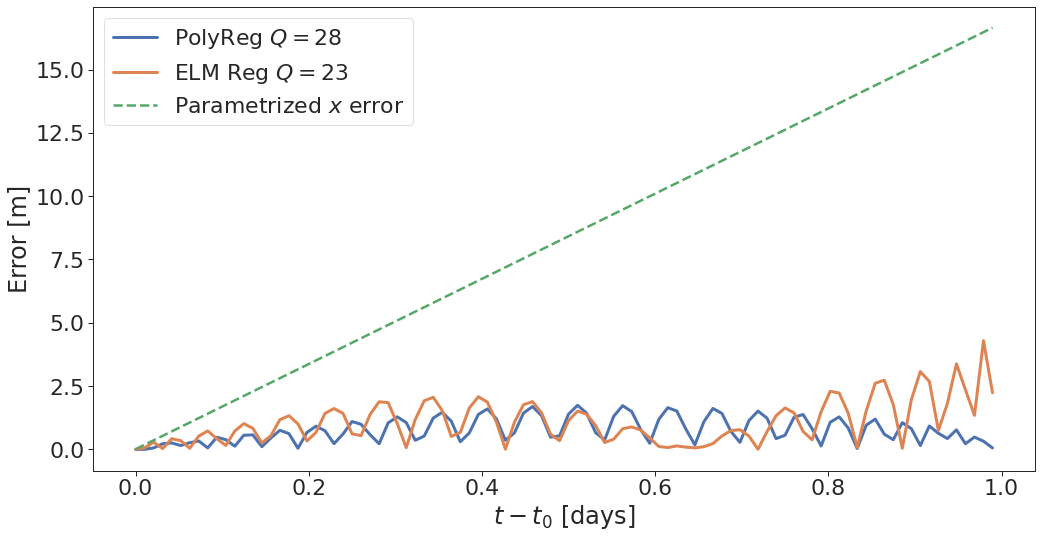

In [43]:
print("#####################","\nMinimum poly deg results:","\nN:",n,
      "\nRMS[m]:",rms,
      "\n#####################\n")
c_poly = np.polynomial.chebyshev.chebfit(rescaled_T.reshape(-1),X.reshape(-1),deg=n,w=weights_array)
poly_pred_data = np.polynomial.Chebyshev(c_poly)(rescaled_T.reshape(-1))

poly_error = (poly_pred_data.reshape(-1)-X.reshape(-1))*1000
poly_mse = mean_squared_error(poly_pred_data,X,squared=False)*1000
poly_max=max_error(poly_pred_data,X)*1000
print("max error",abs(poly_error).max().round(3))
print("rmse",poly_mse.round(3))

timespan=T-T[0]
plt.plot(timespan,abs(poly_error),label="PolyReg $Q="+str(n+1)+"$",linewidth=3)
plt.plot(timespan,abs(elm_error),label="ELM Reg $Q="+str(N+2)+"$",linewidth=3)
plt.plot(timespan,measure_error*1000,label="Parametrized $x$ error",linewidth=2.5,linestyle="dashed")
# plt.title(str(days)+" days")
plt.xlabel("$t-t_0$ [days]")
plt.ylabel("Error [m]")
plt.legend()
plt.tight_layout()
# plt.savefig("logs_plots/"+str(days)+"d_weighted.png",dpi=300);

In [44]:
#for latex table
print("\\textbf{ELM} &",N+2,"&",np.round(len(rescaled_T)/(N+2),3),"&",best_w_seed,"&",best_b_seed,"&",elm_mse.round(3),"&",elm_max.round(3),"\\\\")
print("\\textbf{PolyReg} &",n+1,"&",np.round(len(rescaled_T)/(n+1),3),"&-&-&",poly_mse.round(3),"&",poly_max.round(3),"\\\\")

\textbf{ELM} & 23 & 4.174 & 368623519 & 221799650 & 1.368 & 4.294 \\
\textbf{PolyReg} & 28 & 3.429 &-&-& 0.913 & 1.742 \\
